In [7]:
import numpy as np
import cv2
import matplotlib as plt
from sklearn.feature_extraction.image import extract_patches_2d

In [16]:
def contrast_saliency(R1, R2):
    h1, w1, n_chan = R1.shape
    h2, w2, n_chan = R2.shape
    N1 = h1*w1
    N2 = h2*w2
    
    return np.linalg.norm(np.mean(R1, axis=(0,1)), np.mean(R2, axis=(0,1)))
    
def extract_region(image, scale):
    h, w, n_chan = image.shape
    pad_im = np.pad(image, int(scale/2), mode='symmetric')
    regions = extract_patches_2d(pad_im, (scale,scale))
    print(regions.shape)
    regions = np.reshape(regions, (h, w, scale, scale, n_chan))
    return regions

def mean_saliency(image, scale_1):
    h, w, n_chan = image.shape
    w2 = min(h,w)
    scales_2 = [w2/2, w2/4, w2/8]
    c_mat = np.zeros((3,h,w))
    reg_1 = extract_region(image, 1)
    for s in range(3):
        reg_2 = extract_region(image, scales_2[s])
        for i in range(h):
            for j in range(w):
                c_mat[s,i,j] = contrast_saliency(reg_1[i,j,:,:,:], reg_2[i,j,:,:,:])
    return c_mat

def get_limits(i, j, n_H, n_W, W_R):
    maxi_x = min(n_H, i + 1 + W_R//2)
    maxi_y = min(n_W, j + 1 + W_R//2)
    mini_x = max(0, i - W_R//2)
    mini_y = max(0, j - W_R//2)
    N = (maxi_x - mini_x + 1)*(maxi_y - mini_y + 1)
    return mini_x, mini_y, maxi_x, maxi_y, N
    
def extract_saliency(img):
    n_H, n_W, n_channel = img.shape
    W_R2 = min(n_H,n_W)/8
    N2 = W_R2**2
    print(W_R2)
    integral_img = cv2.integral(im)
    saliency_map = np.zeros((n_H,n_W))
    for i in range(n_H):
        for j in range(n_W):
            mini_x, mini_y, maxi_x, maxi_y, N = get_limits(i, j, n_H, n_W, W_R2)
            tmp = 1.0*(integral_img[mini_x,mini_y,:] + integral_img[maxi_x,maxi_y,:]\
                       - (integral_img[mini_x,maxi_y,:] \
                          + integral_img[maxi_x,mini_y,:]))/N
            saliency_map[i,j] = np.linalg.norm(img[i,j,:]-np.array(tmp))
    return saliency_map

(501, 420, 3)


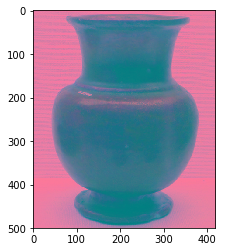

In [8]:
image = cv2.imread("MSO/img/COCO_COCO_train2014_000000026171.jpg")
im = cv2.cvtColor(image,cv2.COLOR_BGR2LAB)
%matplotlib inline
plt.pyplot.imshow(im)
i_im = cv2.integral(im)
print(i_im.shape)

52
(500, 419)


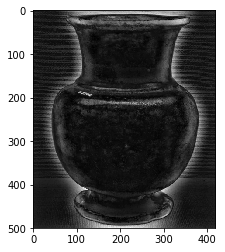

In [17]:
s = extract_saliency(im)
print(s.shape)
plt.pyplot.imshow(s,cmap='gray')

In [ ]:
.